# Diagnostiquez automatiquement des radios thoraciques.

Maintenant que vous avez découvert les CNN et que vous savez entraîner des modèles avec Pytorch, vous allez pouvoir utiliser vos nouvelles connaissances pour résoudre un problème plus concret.

Dans ce notebook, vous allez entraîner un algorithme capable de diagnostiquer automatiquement si notre patient est atteint d'une pneumonie ou non grâce à sa radiographie thoracique. Les données viennent de ce [datasets](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) de Kaggle.


# Importation des packages

In [15]:
import matplotlib.pyplot as plt

import os
import numpy as np

from sklearn.metrics import accuracy_score, confusion_matrix

import torch as torch
from torchvision import datasets, transforms
from torchsummary import summary
from collections import OrderedDict

from torch.utils.data import Subset

# Importation des données

Ajoutez un raccourci de ce dossier à votre google drive :

https://drive.google.com/drive/folders/1F1MiX9qQ7ZoafVq68x6ISWgtOsZf7CCi?usp=sharing

In [16]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Visualisons nos données !

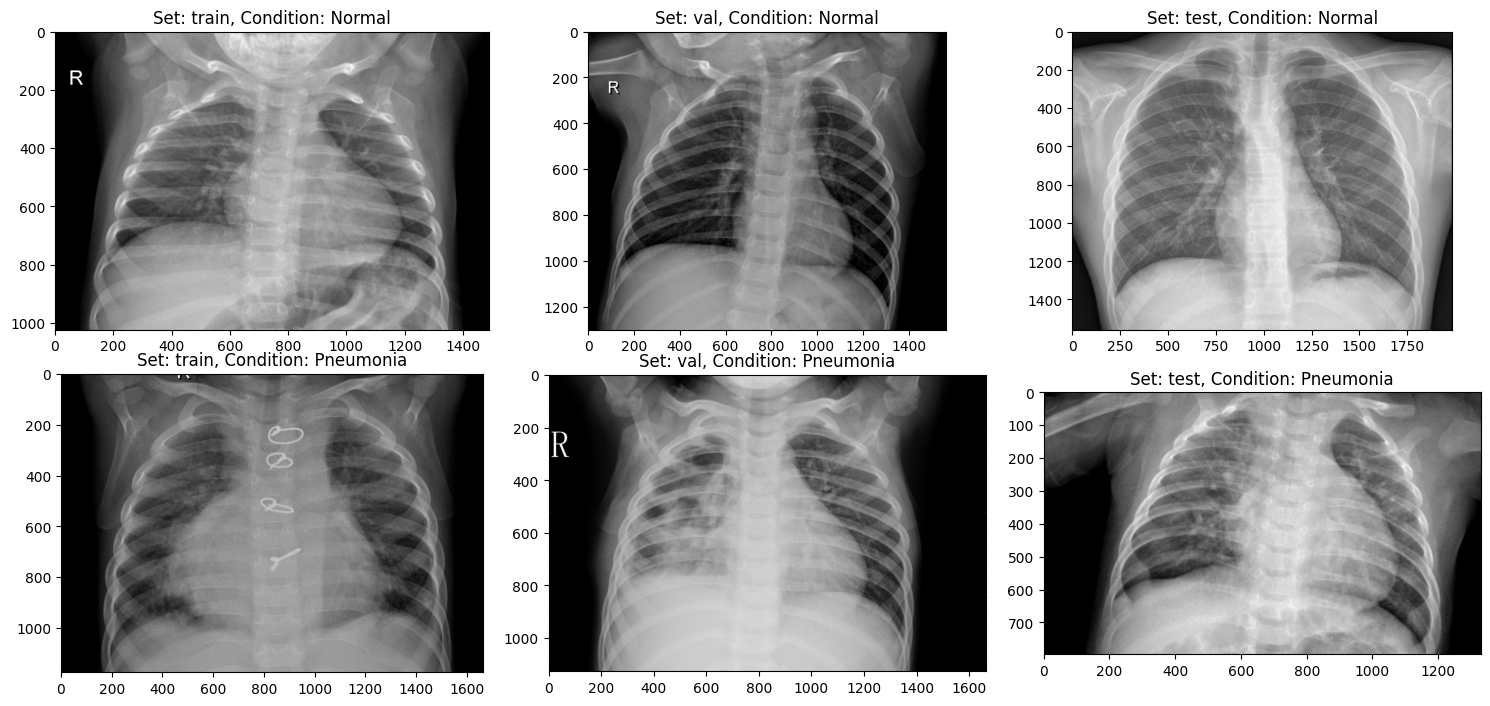

In [17]:

input_path = '/content/drive/MyDrive/chest_xray/'

fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL') [i]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA') [i]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

In [18]:
normal_example = os.listdir(f'{input_path}train/NORMAL')[3]
pneumonia_example = os.listdir(f'{input_path}train/PNEUMONIA')[3]

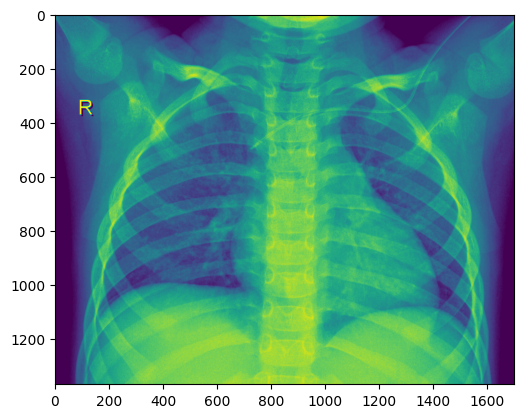

In [19]:
normal_img = plt.imread(f'{input_path}train/NORMAL/{normal_example}')
plt.imshow(normal_img)
plt.show()

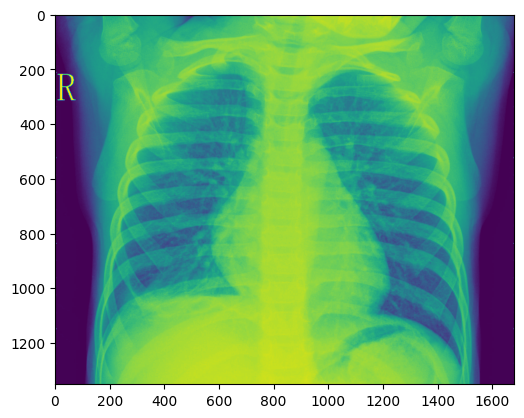

In [20]:
pneumonia_img = plt.imread(f'{input_path}train/PNEUMONIA/{pneumonia_example}')
plt.imshow(pneumonia_img)
plt.show()

In [21]:
test_labels = []
for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path + 'test' + cond)):
          if cond=='/NORMAL/':
              label = 0
          elif cond=='/PNEUMONIA/':
              label = 1
          test_labels.append(label)

test_labels = np.array(test_labels)

# Initialiser les générateurs

Utilisez la classe *transforms* pour appliquer des transformation à vos images. C'est cette classe qui est aussi utilisez pour effectuer de la data augmentation.

Appliquez :
- `Resize` en 255x255 pour réduire le nombre de paramètres,
- `Grayscale`,
- `ToTensor` pour transformer l'image en tenseur.

N'hésitez pas à chercher de l'aide dans la [documentation](https://pytorch.org/vision/0.9/transforms.html).

In [22]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

Utilisez la fonction `ImageFolder` en utilisant le path ou se trouve les données '/content/drive/MyDrive/chest_xray/train_small' et la fonction `transform`.

N'hésitez pas à regarder la [documentation](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html).

In [23]:
dataset_train = datasets.ImageFolder('/content/drive/MyDrive/chest_xray/train_small', transform=transform)

Vous n'allez pas charger directement toutes les images en mémoire pendant l'entraînement. Vous allez utilisez la fonction *flow_from_directory* pour renseigner l'endroit ou se trouve vos images. Les images seront lu batch par batch.

Utilisez :
- `dataset` ,
- un batch de 32 ,
- un shuffle à True.

N'hésitez pas à regarder la [documentation](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

In [24]:
dataloader_train = torch.utils.data.DataLoader(dataset_train, 32, True)

Visualisation du générateur.

torch.Size([1, 128, 128])
tensor(0)


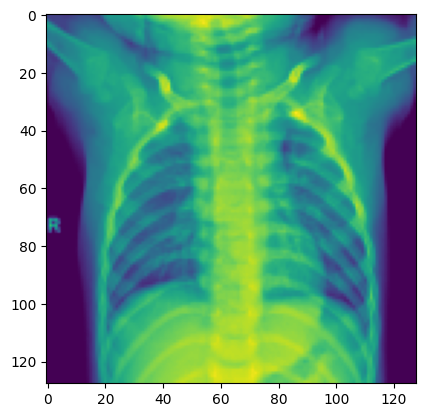

In [25]:
for x, y in dataloader_train:
  print(x[0].shape)
  print(y[0])
  plt.imshow(x[0].permute(1, 2, 0))
  break

Faire de même pour le jeu de test et de validation.

In [26]:
dataset_test = datasets.ImageFolder('/content/drive/MyDrive/chest_xray/val', transform=transform)

dataloader_test = torch.utils.data.DataLoader(dataset_train, 32, True)

# Initialisez votre modèle

Créez l'architecture suivante:
- Convolution avec 16 filtres de 3 de côté,
- Relu,
- Maxpooling avec 2 de côté et un stride de 2,
- Convolution avec 32 filtres de 3 de côté,
- Relu,
- Maxpooling avec 2 de côté et un stride de 2,
- Convolution avec 64 filtres de 3 de côté,
- Relu,
- Maxpooling avec 2 de côté et un stride de 2,
- Convolution avec 128 filtres de 3 de côté,
- Relu,
- Maxpooling avec 2 de côté et un stride de 2,
- Flatten,
- Linear avec 4608 données en entrée et 64 neurones,
- Relu,
- Linear avec 10 neurones,
- Softmax.

In [27]:
model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 16, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2,2),
    torch.nn.Conv2d(16, 32, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2,2),
    torch.nn.Conv2d(32, 64, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2,2),
    torch.nn.Conv2d(64, 128, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2,2),
    torch.nn.Flatten(),
    torch.nn.Linear(4608, 64), torch.nn.ReLU(),
    torch.nn.Linear(64, 10),
    torch.nn.LogSoftmax(dim=1)

)

Affiche l'architecture avec `print`

In [ ]:
print(model)

Affiche le modèle en utilisant `summary`.

In [29]:
summary(model, (1,128,128), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 126, 126]             160
              ReLU-2         [-1, 16, 126, 126]               0
         MaxPool2d-3           [-1, 16, 63, 63]               0
            Conv2d-4           [-1, 32, 61, 61]           4,640
              ReLU-5           [-1, 32, 61, 61]               0
         MaxPool2d-6           [-1, 32, 30, 30]               0
            Conv2d-7           [-1, 64, 28, 28]          18,496
              ReLU-8           [-1, 64, 28, 28]               0
         MaxPool2d-9           [-1, 64, 14, 14]               0
           Conv2d-10          [-1, 128, 12, 12]          73,856
             ReLU-11          [-1, 128, 12, 12]               0
        MaxPool2d-12            [-1, 128, 6, 6]               0
          Flatten-13                 [-1, 4608]               0
           Linear-14                   

# Les fonctions d'entraînement

Utilisez la fonction `save` pour sauver le modèle passé en paramètre au chemin indiqué en paramètre.

In [44]:
def save_model(model, path):
    torch.save(model.state_dict(), path)

In [45]:
def number_of_good_prediction(prediction:float, target:int):
  one_hot_prediction = np.argmax(prediction, axis=1)
  return np.sum(one_hot_prediction == target)

In [46]:
def step(model:torch.nn.Sequential,
         opt:torch.optim,
         criterion:torch.nn.modules.loss,
         x_train:torch.Tensor,
         y_train:torch.Tensor,
         metric_function)->tuple:
  """
  Executes a single training step for a PyTorch model.
  This function performs a forward pass to compute the model's predictions, calculates
  the loss between predictions and actual target values, computes gradients for each
  model parameter, and updates the parameters using the optimizer.

  Args:
      model (torch.nn.Sequential): The PyTorch model to train.
      optimizer (torch.optim.Optimizer): Optimizer used to update the model's parameters.
      criterion (torch.nn.modules.loss._Loss): Loss function used to compute the error.
      x_train (torch.Tensor): Input training data (features).
      y_train (torch.Tensor): Ground truth labels or target values for the training data.
  Returns:
      tuple: The updated model and the computed loss for the current step.
  """

  # Réinitialisez les gradients d'optimizer à zéro avec la méthode 'zero_grad'
  opt.zero_grad()

  # Calculez les prédiction sur le jeu d'entraînement avec la méthode 'froward'
  prediction = model.forward(x_train)

  # Calculez l'erreur de prédiction avec 'criterion'
  loss = criterion(prediction, y_train)

  performance = metric_function(prediction.detach().numpy(), y_train.detach().numpy())

  # Calculez les gradients avec la méthode 'backward'
  loss.backward()

  # Mettre à jour les paramètres du modèle avec la méthode 'step'
  opt.step()

  return model, loss, performance

In [47]:
def fit(model, optimizer, criterion, epoch, trainloader, testloader, metric_function):
    epoch = epoch
    history_train_loss = []
    history_test_loss = []
    history_train_metrics = []
    history_test_metrics = []

    reference_performance = 0

    for e in range(epoch) :

      train_loss_batch = 0
      test_loss_batch = 0
      train_metric_batch = 0
      test_metric_batch = 0

      for images, labels in trainloader:

        # mise à jour des poids avec la fonction 'step'
        model, train_loss, train_performance = step(model, optimizer, criterion, images, labels, metric_function)

        train_loss_batch += train_loss.detach().numpy()

        train_metric_batch += train_performance


      for images, labels in testloader:

        prediction = model.forward(images)

        test_loss = criterion(prediction, labels)

        test_metric_batch += metric_function(prediction.detach().numpy(), labels.detach().numpy())

        test_loss_batch += test_loss.detach().numpy()

      train_loss_batch /= len(trainloader.sampler)
      test_loss_batch /= len(testloader.sampler)

      train_metric_batch /= len(trainloader.sampler)
      test_metric_batch /= len(testloader.sampler)

      # Sauvegarde des coûts d'entraînement avec append
      history_train_loss = np.append(history_train_loss, train_loss_batch)
      history_test_loss = np.append(history_test_loss, test_loss_batch)

      # Sauvegarde des coûts d'entraînement avec append
      history_train_metrics = np.append(history_train_metrics, train_metric_batch)
      history_test_metrics = np.append(history_test_metrics, test_metric_batch)

      print('train_loss : '+str(np.squeeze(train_loss_batch))+ ' test_loss : '+str(np.squeeze(test_loss_batch)))
      print('train_metric : '+str(np.squeeze(train_metric_batch))+ ' test_metric : '+str(np.squeeze(test_metric_batch)))
      print('-------------------------------------------------------------------------------------------------')

      if test_metric_batch > reference_performance:
        reference_performance = test_metric_batch
        save_model(model, f'best_model_{test_metric_batch}.pth')

    return model, history_train_loss, history_test_loss, history_train_metrics, history_test_metrics


Initialisez `criterion` avec la fonction `NLLLoss`.

Initialisez `optimizer` avec `Adam` et un learning rate de 0.001.

In [48]:
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters())

# Entraînez votre modèle

In [49]:
epoch = 10

Utilisez la fonction `fit` pour entraîner le modèle.

In [50]:
model, history_train_loss, history_test_loss, history_train_metrics, history_test = fit(model, optimizer, criterion, epoch, dataloader_train, dataloader_test, number_of_good_prediction)

train_loss : 0.027179066836833955 test_loss : 0.025291908284028372
train_metric : 0.55 test_metric : 0.5
-------------------------------------------------------------------------------------------------
train_loss : 0.026756384472052256 test_loss : 0.024437856674194337
train_metric : 0.5 test_metric : 0.5
-------------------------------------------------------------------------------------------------
train_loss : 0.023622794449329375 test_loss : 0.02484451134999593
train_metric : 0.55 test_metric : 0.5
-------------------------------------------------------------------------------------------------
train_loss : 0.024858213464419045 test_loss : 0.023724569380283354
train_metric : 0.5 test_metric : 0.5
-------------------------------------------------------------------------------------------------
train_loss : 0.02406504899263382 test_loss : 0.023556090394655862
train_metric : 0.43333333333333335 test_metric : 0.5
------------------------------------------------------------------------

# Visualisation des performances

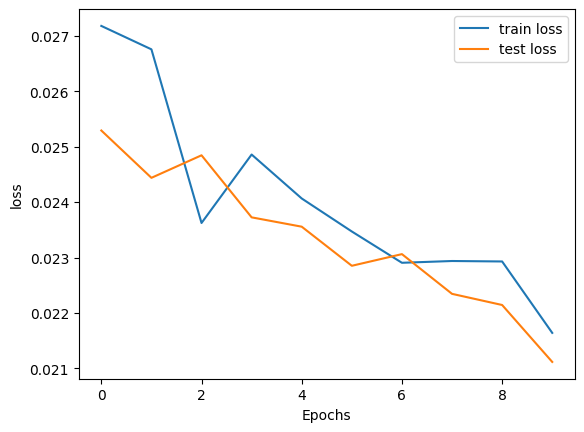

In [51]:
plt.plot(np.arange(epoch), history_train_loss, label='train loss')
plt.plot(np.arange(epoch), history_test_loss, label='test loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend(loc='upper left')
plt.legend()
plt.show()

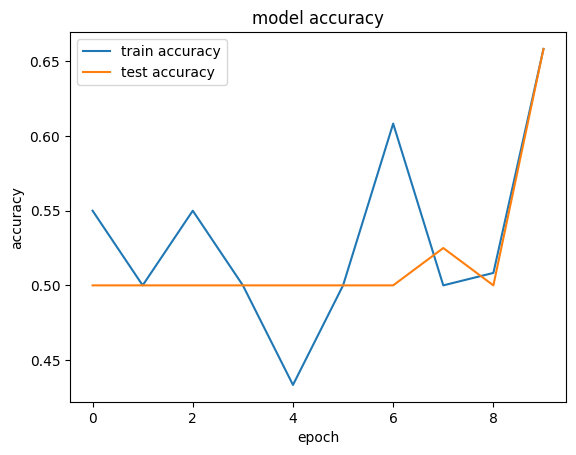

In [52]:
plt.plot(history_train_metrics, label='train accuracy')
plt.plot(history_test, label='test accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()